In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import sys

sys_epsilon = sys.float_info.epsilon

In [2]:
headers = ["t", "Ux", "Uy", "Uz", 
           "G1", "G2", "G3", "G4", "G5", "G6", 
           "S1", "S2", "S3", "S4", "S5", "S6", 
           "UUp1", "UUp2", "UUp3", "UUp4", "UUp5", "UUp6", 
           "Cs"]

R103 = pd.read_csv('./datasets/fieldData_R103_norm.txt', sep=' ', names=headers)
R503 = pd.read_csv('./datasets/fieldData_R503_norm.txt', sep=' ', names=headers)
R104 = pd.read_csv('./datasets/fieldData_R104_norm.txt', sep=' ', names=headers)

In [3]:
R103.head()

,t,Ux,Uy,Uz,G1,G2,G3,G4,G5,G6,...,S4,S5,S6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,-1.027122,-0.000607,-0.001033,0.001586,0.003769,-0.000243,-0.000310,0.001519,-0.004942,-0.002082,...,-0.004942,0.000056,-0.001784,-0.134213,-0.010852,0.009912,-0.153644,-0.045258,-0.150407,-0.232084
1,-1.027122,0.048423,-0.002944,-0.000262,0.021788,-0.000289,-0.000408,0.001519,-0.017760,-0.002090,...,-0.017760,0.000042,-0.015981,-0.134199,-0.010853,0.009911,-0.153644,-0.045258,-0.150407,-0.191414
2,-1.027122,0.146858,-0.000820,0.001179,0.005336,0.000219,0.000182,0.001882,-0.003509,-0.002079,...,-0.003509,0.000060,-0.004908,-0.133998,-0.010854,0.009910,-0.153644,-0.045258,-0.150406,0.044781
3,-1.027122,0.095208,-0.000137,0.002144,-0.003282,-0.000302,-0.000333,0.001519,0.001063,-0.002076,...,0.001063,0.000066,0.002495,-0.133893,-0.010854,0.009910,-0.153644,-0.045258,-0.150406,0.088803
4,-1.027122,0.078927,-0.000084,0.001453,-0.000148,-0.000061,-0.000199,0.001519,0.001425,-0.002077,...,0.001425,0.000064,-0.002813,-0.133738,-0.010855,0.009909,-0.153644,-0.045258,-0.150406,-0.099000


In [4]:
frames = [R103, R503, R104]
df = pd.concat(frames)
df.shape

(26697608, 23)

In [5]:
M1_headers = ['Ux', 'Uy', 'Uz', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M2_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S1',  'S2', 'S3', 'S4', 'S5', 'S6', 'Cs']
M3_headers = ['Ux', 'Uy', 'Uz', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']
M4_headers = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'UUp1',  'UUp2', 'UUp3', 'UUp4', 'UUp5', 'UUp6', 'Cs']

M1_103 = R103.filter(M1_headers, axis=1)
M2_103 = R103.filter(M2_headers, axis=1)
M3_103 = R103.filter(M3_headers, axis=1)
M4_103 = R103.filter(M4_headers, axis=1)

M1_503 = R503.filter(M1_headers, axis=1)
M2_503 = R503.filter(M2_headers, axis=1)
M3_503 = R503.filter(M3_headers, axis=1)
M4_503 = R503.filter(M4_headers, axis=1)

M1_104 = R104.filter(M1_headers, axis=1)
M2_104 = R104.filter(M2_headers, axis=1)
M3_104 = R104.filter(M3_headers, axis=1)
M4_104 = R104.filter(M4_headers, axis=1)

M1 = df.filter(M1_headers, axis=1)
M2 = df.filter(M2_headers, axis=1)
M3 = df.filter(M3_headers, axis=1)
M4 = df.filter(M4_headers, axis=1)

In [6]:
M1.shape, M2.shape

((26697608, 10), (26697608, 13))

In [8]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [102]:
dt = M4_503
dt_name = namestr(M4_503, globals())[0]
output_size = 1
input_size = dt.shape[1] - output_size 
neurons_per_layer = [60, 60, 60, 60, 60] #[120, 60, 30, 20, 10, 10, 20, 30, 60]
hidden_layers = len(neurons_per_layer)   
#latent_size = 20  

In [103]:
dt.head()

,G1,G2,G3,G4,G5,G6,UUp1,UUp2,UUp3,UUp4,UUp5,UUp6,Cs
0,0.000738,-0.000526,0.000439,-0.000355,-0.000045,-0.000941,-0.116831,0.002460,-0.001456,-0.141552,0.006636,-0.142795,-0.472658
1,0.005381,-0.000548,0.000419,-0.000355,-0.002436,-0.000941,-0.116830,0.002460,-0.001456,-0.141552,0.006636,-0.142795,-0.144178
2,0.011798,-0.000567,0.000410,-0.000420,-0.005874,-0.000945,-0.116829,0.002459,-0.001456,-0.141552,0.006636,-0.142795,-0.146722
3,0.017124,-0.000483,0.000490,-0.000355,-0.008891,-0.000958,-0.116821,0.002459,-0.001456,-0.141552,0.006636,-0.142795,-0.146788
4,0.012754,-0.000333,0.000658,-0.000290,-0.006874,-0.000944,-0.116801,0.002459,-0.001456,-0.141552,0.006636,-0.142795,-0.143898


In [104]:
#dt.to_csv(f'./{dt_name}.txt', sep=' ', index=False, encoding='utf-8', header=False)

In [105]:
mask = np.random.rand(len(dt)) < 0.8
train_val = dt[mask]
test = dt[~mask].to_numpy()

mask = np.random.rand(len(train_val)) < 0.8
train = train_val[mask].to_numpy()
val = train_val[~mask].to_numpy()

In [106]:
dt.shape, train.shape[0], val.shape[0], test.shape[0]

((6172628, 13), 3949968, 986937, 1235723)

In [107]:
batch_sz_trn = 4096
batch_sz_val = int(batch_sz_trn / 4)
batch_sz_tst = int(batch_sz_trn / 4)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_sz_trn, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_sz_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_sz_tst, shuffle=True)

In [108]:
data_iter = iter(train_loader)
next(data_iter)[0]

tensor([ 1.6528e-01, -4.7454e-03, -5.6232e-02, -6.4798e-03,  1.0020e-01,
         1.1777e-01, -7.2796e-02,  1.5963e-02,  7.5270e-02, -8.2913e-02,
         4.8199e-01,  2.6602e-02,  6.9009e+00], dtype=torch.float64)

In [109]:
def coeff_determination(y_true, y_pred):
    SS_res = torch.sum(torch.square( y_true - y_pred ))
    SS_tot = torch.sum(torch.square( y_true - torch.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + sys_epsilon) )

In [110]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, neurons_per_layer):
        super(MLPModel, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(neurons_per_layer[-1], output_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x


In [111]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, hidden_layers, neurons_per_layer):
        super(Autoencoder, self).__init__()

        # Encoder layers
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_size, neurons_per_layer[0]))
        encoder_layers.append(nn.ReLU())

        for i in range(1, hidden_layers):
            encoder_layers.append(nn.Linear(neurons_per_layer[i - 1], neurons_per_layer[i]))
            encoder_layers.append(nn.ReLU())

        encoder_layers.append(nn.Linear(neurons_per_layer[-1], latent_size))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_size, neurons_per_layer[-1]))
        decoder_layers.append(nn.ReLU())

        for i in range(hidden_layers - 1, 0, -1):
            decoder_layers.append(nn.Linear(neurons_per_layer[i], neurons_per_layer[i - 1]))
            decoder_layers.append(nn.ReLU())

        decoder_layers.append(nn.Linear(neurons_per_layer[0], 1))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        # Encode input
        encoded = self.encoder(x)

        # Decode
        decoded = self.decoder(encoded)

        return decoded


In [112]:
model = MLPModel(input_size=input_size, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

In [113]:
#model = Autoencoder(input_size, latent_size, hidden_layers, neurons_per_layer)

In [114]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

In [115]:
#criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [116]:
device = torch.device("cuda")
model.to(device)
model.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=12, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [117]:
class EarlyStopper:
    def __init__(self, patience=1, path=None):
        self.patience = patience
        self.path = path
        self.counter = 0
        self.min_val_loss = float('inf')

    def early_stop(self, model_stat, val_loss):
        if val_loss < self.min_val_loss:
            torch.save(model_stat, self.path)
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + sys_epsilon):
            self.counter += 1
            if self.counter >= self.patience:
                print('+++ Early Stopping is reached! +++')
                return True
        return False

In [ ]:
epochs = 6000
best = 1e6
PATH = f"./best_model_{dt_name}.pt"

early_stopper = EarlyStopper(patience=50, path=PATH)
                             
for epoch in range(epochs):
    model.train()
    Loss_train = 0 
    Loss_val = 0
    coeff_train = 0
    coeff_val = 0
    with tqdm(train_loader, unit="batch") as trainer:
        for batch in trainer:
            trainer.set_description("Train")
            train_feat = batch[:, 0:-1].to(device)
            train_labs = batch[:, -1].to(device)
            train_pred = model(train_feat).squeeze()
            train_loss = torch.nn.functional.mse_loss(train_pred, train_labs)
            train_coef = coeff_determination(train_labs, train_labs) 

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            Loss_train += train_loss.item()
            coeff_train += train_coef

        Loss_train /= batch_sz_trn
        coeff_train /= batch_sz_trn

    model.eval()
    with tqdm(val_loader, unit="batch") as validator:
        for batch in validator:
            validator.set_description("Valdt")
            val_feat = batch[:, 0:-1].to(device)
            val_labs = batch[:, -1].to(device)
            val_pred = model(val_feat).squeeze()
            val_loss = torch.nn.functional.mse_loss(val_pred, val_labs)
            val_coef = coeff_determination(val_labs, val_labs) 

            Loss_val += val_loss.item()
            coeff_val += val_coef

        Loss_val /= batch_sz_val
        coeff_val /= batch_sz_val
    
    if early_stopper.early_stop(model.state_dict(), Loss_val):             
        break
        
    print(f"Epoch: {epoch} / {epochs}, \n Train -- Loss: {Loss_train}, Coeff: {coeff_train} \n Val   -- Loss: {Loss_val}, Coeff: {coeff_val} \n\n")

Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.03batch/s]


Epoch: 0 / 6000, 
 Train -- Loss: 0.2147311471363891, Coeff: 0.235595703125 
 Val   -- Loss: 0.9221174666173586, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 232.24batch/s]


Epoch: 1 / 6000, 
 Train -- Loss: 0.20654897392471624, Coeff: 0.235595703125 
 Val   -- Loss: 0.9005269713202394, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.49batch/s]


Epoch: 2 / 6000, 
 Train -- Loss: 0.20136775603249016, Coeff: 0.235595703125 
 Val   -- Loss: 0.8775043050558224, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.53batch/s]


Epoch: 3 / 6000, 
 Train -- Loss: 0.19751006327891762, Coeff: 0.235595703125 
 Val   -- Loss: 0.8579790158522941, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 225.45batch/s]


Epoch: 4 / 6000, 
 Train -- Loss: 0.1947818751629143, Coeff: 0.235595703125 
 Val   -- Loss: 0.8607840845787809, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.29batch/s]


Epoch: 5 / 6000, 
 Train -- Loss: 0.19236573383261196, Coeff: 0.235595703125 
 Val   -- Loss: 0.846785886003223, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 244.41batch/s]


Epoch: 6 / 6000, 
 Train -- Loss: 0.19128404018880485, Coeff: 0.235595703125 
 Val   -- Loss: 0.8362689344051091, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.76batch/s]


Epoch: 7 / 6000, 
 Train -- Loss: 0.18968350381743776, Coeff: 0.235595703125 
 Val   -- Loss: 0.8331334768235759, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 225.89batch/s]


Epoch: 8 / 6000, 
 Train -- Loss: 0.18867295213104793, Coeff: 0.235595703125 
 Val   -- Loss: 0.8381889148120264, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 239.46batch/s]


Epoch: 9 / 6000, 
 Train -- Loss: 0.1875185141373293, Coeff: 0.235595703125 
 Val   -- Loss: 0.8278749996122649, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.28batch/s]


Epoch: 10 / 6000, 
 Train -- Loss: 0.18640004522018078, Coeff: 0.235595703125 
 Val   -- Loss: 0.8352103997187347, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.89batch/s]


Epoch: 11 / 6000, 
 Train -- Loss: 0.18572029884865524, Coeff: 0.235595703125 
 Val   -- Loss: 0.8284822790161687, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.70batch/s]


Epoch: 12 / 6000, 
 Train -- Loss: 0.1843741556678672, Coeff: 0.235595703125 
 Val   -- Loss: 0.8309054586146416, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 236.49batch/s]


Epoch: 13 / 6000, 
 Train -- Loss: 0.18396740655978805, Coeff: 0.235595703125 
 Val   -- Loss: 0.8196003032064196, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 229.61batch/s]


Epoch: 14 / 6000, 
 Train -- Loss: 0.18346052965884135, Coeff: 0.235595703125 
 Val   -- Loss: 0.8167798793087218, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 236.74batch/s]


Epoch: 15 / 6000, 
 Train -- Loss: 0.18274414002667982, Coeff: 0.235595703125 
 Val   -- Loss: 0.8164932397377622, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 240.84batch/s]


Epoch: 16 / 6000, 
 Train -- Loss: 0.181631992958483, Coeff: 0.235595703125 
 Val   -- Loss: 0.8100290730406687, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 231.26batch/s]


Epoch: 17 / 6000, 
 Train -- Loss: 0.1811203831713315, Coeff: 0.235595703125 
 Val   -- Loss: 0.8270138028382985, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 239.90batch/s]


Epoch: 18 / 6000, 
 Train -- Loss: 0.18035842669563462, Coeff: 0.235595703125 
 Val   -- Loss: 0.8111238745031849, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 240.01batch/s]


Epoch: 19 / 6000, 
 Train -- Loss: 0.18044565315218974, Coeff: 0.235595703125 
 Val   -- Loss: 0.8095527869756244, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.40batch/s]


Epoch: 20 / 6000, 
 Train -- Loss: 0.17942113299363693, Coeff: 0.235595703125 
 Val   -- Loss: 0.8160862059272389, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.65batch/s]


Epoch: 21 / 6000, 
 Train -- Loss: 0.17872424347220997, Coeff: 0.235595703125 
 Val   -- Loss: 0.8151802474463802, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.29batch/s]


Epoch: 22 / 6000, 
 Train -- Loss: 0.1783289489136336, Coeff: 0.235595703125 
 Val   -- Loss: 0.8219909696133643, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.58batch/s]


Epoch: 23 / 6000, 
 Train -- Loss: 0.1778529853241506, Coeff: 0.235595703125 
 Val   -- Loss: 0.8169422693658581, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 242.25batch/s]


Epoch: 24 / 6000, 
 Train -- Loss: 0.17752235352494447, Coeff: 0.235595703125 
 Val   -- Loss: 0.8288060619106048, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 238.53batch/s]


Epoch: 25 / 6000, 
 Train -- Loss: 0.17738387015279736, Coeff: 0.235595703125 
 Val   -- Loss: 0.813337210990967, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 241.11batch/s]


Epoch: 26 / 6000, 
 Train -- Loss: 0.17634887396084284, Coeff: 0.235595703125 
 Val   -- Loss: 0.8142528841419794, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.27batch/s]


Epoch: 27 / 6000, 
 Train -- Loss: 0.17552136011398628, Coeff: 0.235595703125 
 Val   -- Loss: 0.8057249390190677, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 229.24batch/s]


Epoch: 28 / 6000, 
 Train -- Loss: 0.17561911521577964, Coeff: 0.235595703125 
 Val   -- Loss: 0.8239099578753948, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 236.77batch/s]


Epoch: 29 / 6000, 
 Train -- Loss: 0.1755036517931414, Coeff: 0.235595703125 
 Val   -- Loss: 0.8072206591441204, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.43batch/s]


Epoch: 30 / 6000, 
 Train -- Loss: 0.17465227358331237, Coeff: 0.235595703125 
 Val   -- Loss: 0.8034043662084004, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 228.57batch/s]


Epoch: 31 / 6000, 
 Train -- Loss: 0.1741317302537786, Coeff: 0.235595703125 
 Val   -- Loss: 0.8013179801579774, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 236.66batch/s]


Epoch: 32 / 6000, 
 Train -- Loss: 0.1742229970219376, Coeff: 0.235595703125 
 Val   -- Loss: 0.8059799422555908, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.93batch/s]


Epoch: 33 / 6000, 
 Train -- Loss: 0.17414428217507746, Coeff: 0.235595703125 
 Val   -- Loss: 0.7925909045943359, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 227.80batch/s]


Epoch: 34 / 6000, 
 Train -- Loss: 0.1735726940904997, Coeff: 0.235595703125 
 Val   -- Loss: 0.8015844773872566, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 236.94batch/s]


Epoch: 35 / 6000, 
 Train -- Loss: 0.17394348955304353, Coeff: 0.235595703125 
 Val   -- Loss: 0.8199645312905581, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 245.80batch/s]


Epoch: 36 / 6000, 
 Train -- Loss: 0.173948658789875, Coeff: 0.235595703125 
 Val   -- Loss: 0.7965342519553866, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.67batch/s]


Epoch: 37 / 6000, 
 Train -- Loss: 0.17243499016368105, Coeff: 0.235595703125 
 Val   -- Loss: 0.796505663741426, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 238.82batch/s]


Epoch: 38 / 6000, 
 Train -- Loss: 0.17225836247915713, Coeff: 0.235595703125 
 Val   -- Loss: 0.8019568987108177, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 236.48batch/s]


Epoch: 39 / 6000, 
 Train -- Loss: 0.1721970697027741, Coeff: 0.235595703125 
 Val   -- Loss: 0.8163819981522483, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.09batch/s]


Epoch: 40 / 6000, 
 Train -- Loss: 0.17215556203954266, Coeff: 0.235595703125 
 Val   -- Loss: 0.8005848935770778, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.05batch/s]


Epoch: 41 / 6000, 
 Train -- Loss: 0.17253270129542012, Coeff: 0.235595703125 
 Val   -- Loss: 0.8053662348126086, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.31batch/s]


Epoch: 42 / 6000, 
 Train -- Loss: 0.17075089925872722, Coeff: 0.235595703125 
 Val   -- Loss: 0.7980178473990923, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 239.25batch/s]


Epoch: 43 / 6000, 
 Train -- Loss: 0.17118284564066616, Coeff: 0.235595703125 
 Val   -- Loss: 0.8059549262829332, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.98batch/s]


Epoch: 44 / 6000, 
 Train -- Loss: 0.17145970171502498, Coeff: 0.235595703125 
 Val   -- Loss: 0.799667002466384, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 227.72batch/s]


Epoch: 45 / 6000, 
 Train -- Loss: 0.1704349509046059, Coeff: 0.235595703125 
 Val   -- Loss: 0.8042120941510607, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 240.59batch/s]


Epoch: 46 / 6000, 
 Train -- Loss: 0.171052917819211, Coeff: 0.235595703125 
 Val   -- Loss: 0.815897688447726, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.48batch/s]


Epoch: 47 / 6000, 
 Train -- Loss: 0.16992665681678534, Coeff: 0.235595703125 
 Val   -- Loss: 0.8017099947388441, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.21batch/s]


Epoch: 48 / 6000, 
 Train -- Loss: 0.17000999597551245, Coeff: 0.235595703125 
 Val   -- Loss: 0.8085484704728789, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 228.90batch/s]


Epoch: 49 / 6000, 
 Train -- Loss: 0.1700901717782548, Coeff: 0.235595703125 
 Val   -- Loss: 0.7968304957883586, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 232.25batch/s]


Epoch: 50 / 6000, 
 Train -- Loss: 0.16968190484307663, Coeff: 0.235595703125 
 Val   -- Loss: 0.8024239635479874, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.11batch/s]


Epoch: 51 / 6000, 
 Train -- Loss: 0.16968175242213357, Coeff: 0.235595703125 
 Val   -- Loss: 0.8045757754268604, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 240.54batch/s]


Epoch: 52 / 6000, 
 Train -- Loss: 0.1687723299563226, Coeff: 0.235595703125 
 Val   -- Loss: 0.7960802449880452, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.05batch/s]


Epoch: 53 / 6000, 
 Train -- Loss: 0.1696651320179051, Coeff: 0.235595703125 
 Val   -- Loss: 0.8190684844276722, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.27batch/s]


Epoch: 54 / 6000, 
 Train -- Loss: 0.16866477102399313, Coeff: 0.235595703125 
 Val   -- Loss: 0.797153795462285, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 238.85batch/s]


Epoch: 55 / 6000, 
 Train -- Loss: 0.1688832365938469, Coeff: 0.235595703125 
 Val   -- Loss: 0.793807723463844, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 245.18batch/s]


Epoch: 56 / 6000, 
 Train -- Loss: 0.1678651670094614, Coeff: 0.235595703125 
 Val   -- Loss: 0.811098760054986, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 232.97batch/s]


Epoch: 57 / 6000, 
 Train -- Loss: 0.16927942065803847, Coeff: 0.235595703125 
 Val   -- Loss: 0.8104543990318946, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 241.22batch/s]


Epoch: 58 / 6000, 
 Train -- Loss: 0.16929746226638287, Coeff: 0.235595703125 
 Val   -- Loss: 0.8132408055041042, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.94batch/s]


Epoch: 59 / 6000, 
 Train -- Loss: 0.16758217241661758, Coeff: 0.235595703125 
 Val   -- Loss: 0.8024793624932116, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 228.56batch/s]


Epoch: 60 / 6000, 
 Train -- Loss: 0.16668007254632422, Coeff: 0.235595703125 
 Val   -- Loss: 0.8126062143653611, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.97batch/s]


Epoch: 61 / 6000, 
 Train -- Loss: 0.16744854378605697, Coeff: 0.235595703125 
 Val   -- Loss: 0.820480397140719, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 232.73batch/s]


Epoch: 62 / 6000, 
 Train -- Loss: 0.1672651964162696, Coeff: 0.235595703125 
 Val   -- Loss: 0.8038701292871948, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.72batch/s]


Epoch: 63 / 6000, 
 Train -- Loss: 0.16659367556261703, Coeff: 0.235595703125 
 Val   -- Loss: 0.8005593048819537, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.78batch/s]


Epoch: 64 / 6000, 
 Train -- Loss: 0.16664984719839385, Coeff: 0.235595703125 
 Val   -- Loss: 0.7973683709132581, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.45batch/s]


Epoch: 65 / 6000, 
 Train -- Loss: 0.1662599504173107, Coeff: 0.235595703125 
 Val   -- Loss: 0.8023086696866966, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.55batch/s]


Epoch: 66 / 6000, 
 Train -- Loss: 0.1657959409366188, Coeff: 0.235595703125 
 Val   -- Loss: 0.7912697942828221, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 229.57batch/s]


Epoch: 67 / 6000, 
 Train -- Loss: 0.16561655378363105, Coeff: 0.235595703125 
 Val   -- Loss: 0.8044766961279614, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 240.25batch/s]


Epoch: 68 / 6000, 
 Train -- Loss: 0.16553454643909113, Coeff: 0.235595703125 
 Val   -- Loss: 0.8169645596128798, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.49batch/s]


Epoch: 69 / 6000, 
 Train -- Loss: 0.16592715570836739, Coeff: 0.235595703125 
 Val   -- Loss: 0.8071141986727028, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 228.11batch/s]


Epoch: 70 / 6000, 
 Train -- Loss: 0.16496272056361788, Coeff: 0.235595703125 
 Val   -- Loss: 0.8083482808619633, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.78batch/s]


Epoch: 71 / 6000, 
 Train -- Loss: 0.16464368271088692, Coeff: 0.235595703125 
 Val   -- Loss: 0.7961081350078572, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 241.24batch/s]


Epoch: 72 / 6000, 
 Train -- Loss: 0.1639373127951523, Coeff: 0.235595703125 
 Val   -- Loss: 0.7986855016664599, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.82batch/s]


Epoch: 73 / 6000, 
 Train -- Loss: 0.16535466108997748, Coeff: 0.235595703125 
 Val   -- Loss: 0.8004436350242093, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 229.15batch/s]


Epoch: 74 / 6000, 
 Train -- Loss: 0.16537952448277723, Coeff: 0.235595703125 
 Val   -- Loss: 0.8201397247625539, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 236.21batch/s]


Epoch: 75 / 6000, 
 Train -- Loss: 0.16521768796914488, Coeff: 0.235595703125 
 Val   -- Loss: 0.7980214133498519, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 239.58batch/s]


Epoch: 76 / 6000, 
 Train -- Loss: 0.16349279213504034, Coeff: 0.235595703125 
 Val   -- Loss: 0.7967578770592789, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 232.93batch/s]


Epoch: 77 / 6000, 
 Train -- Loss: 0.1638273027422235, Coeff: 0.235595703125 
 Val   -- Loss: 0.7974797439815574, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 232.97batch/s]


Epoch: 78 / 6000, 
 Train -- Loss: 0.1629677386235511, Coeff: 0.235595703125 
 Val   -- Loss: 0.7913416167875156, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.57batch/s]


Epoch: 79 / 6000, 
 Train -- Loss: 0.1626322135900828, Coeff: 0.235595703125 
 Val   -- Loss: 0.7985050239042037, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 236.90batch/s]


Epoch: 80 / 6000, 
 Train -- Loss: 0.16375659114585714, Coeff: 0.235595703125 
 Val   -- Loss: 0.8068118761386884, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 227.38batch/s]


Epoch: 81 / 6000, 
 Train -- Loss: 0.162517904819296, Coeff: 0.235595703125 
 Val   -- Loss: 0.8036867072907062, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.72batch/s]


Epoch: 82 / 6000, 
 Train -- Loss: 0.16225122819831841, Coeff: 0.235595703125 
 Val   -- Loss: 0.7982933515437702, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 238.22batch/s]


Epoch: 83 / 6000, 
 Train -- Loss: 0.16223673291857413, Coeff: 0.235595703125 
 Val   -- Loss: 0.7974172147238578, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 229.69batch/s]


Epoch: 84 / 6000, 
 Train -- Loss: 0.1621128520785082, Coeff: 0.235595703125 
 Val   -- Loss: 0.7925440011114662, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 225.52batch/s]


Epoch: 85 / 6000, 
 Train -- Loss: 0.16309456393144356, Coeff: 0.235595703125 
 Val   -- Loss: 0.8021792963186808, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 243.09batch/s]


Epoch: 86 / 6000, 
 Train -- Loss: 0.16244255076481348, Coeff: 0.235595703125 
 Val   -- Loss: 0.7939271653571247, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 226.53batch/s]


Epoch: 87 / 6000, 
 Train -- Loss: 0.16192560820909382, Coeff: 0.235595703125 
 Val   -- Loss: 0.8004837467404804, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 231.92batch/s]


Epoch: 88 / 6000, 
 Train -- Loss: 0.1624202527084208, Coeff: 0.235595703125 
 Val   -- Loss: 0.7950407842057283, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.29batch/s]


Epoch: 89 / 6000, 
 Train -- Loss: 0.16142298808147557, Coeff: 0.235595703125 
 Val   -- Loss: 0.8144199634166688, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.24batch/s]


Epoch: 90 / 6000, 
 Train -- Loss: 0.16371722722237791, Coeff: 0.235595703125 
 Val   -- Loss: 0.8033391938843069, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.14batch/s]


Epoch: 91 / 6000, 
 Train -- Loss: 0.16153189355663738, Coeff: 0.235595703125 
 Val   -- Loss: 0.8085673345250973, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 224.69batch/s]


Epoch: 92 / 6000, 
 Train -- Loss: 0.1617664136093294, Coeff: 0.235595703125 
 Val   -- Loss: 0.7951798783768493, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 228.73batch/s]


Epoch: 93 / 6000, 
 Train -- Loss: 0.16237526929910145, Coeff: 0.235595703125 
 Val   -- Loss: 0.8015782205514272, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 242.96batch/s]


Epoch: 94 / 6000, 
 Train -- Loss: 0.1621223288944017, Coeff: 0.235595703125 
 Val   -- Loss: 0.798594062133233, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 227.76batch/s]


Epoch: 95 / 6000, 
 Train -- Loss: 0.1615284943589613, Coeff: 0.235595703125 
 Val   -- Loss: 0.7889348477167486, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.80batch/s]


Epoch: 96 / 6000, 
 Train -- Loss: 0.16043891661245763, Coeff: 0.235595703125 
 Val   -- Loss: 0.8080575923217412, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 231.08batch/s]


Epoch: 97 / 6000, 
 Train -- Loss: 0.16154766080798855, Coeff: 0.235595703125 
 Val   -- Loss: 0.7940722451886632, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 238.76batch/s]


Epoch: 98 / 6000, 
 Train -- Loss: 0.1605985766944554, Coeff: 0.235595703125 
 Val   -- Loss: 0.799421794470116, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 232.79batch/s]


Epoch: 99 / 6000, 
 Train -- Loss: 0.15976045793632696, Coeff: 0.235595703125 
 Val   -- Loss: 0.7980335568959332, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 219.78batch/s]


Epoch: 100 / 6000, 
 Train -- Loss: 0.15917144382311577, Coeff: 0.235595703125 
 Val   -- Loss: 0.7957017655805351, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 227.27batch/s]


Epoch: 101 / 6000, 
 Train -- Loss: 0.15969318913137565, Coeff: 0.235595703125 
 Val   -- Loss: 0.8040704650944792, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 239.86batch/s]


Epoch: 102 / 6000, 
 Train -- Loss: 0.1632233573277307, Coeff: 0.235595703125 
 Val   -- Loss: 0.8099255773687154, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.91batch/s]


Epoch: 103 / 6000, 
 Train -- Loss: 0.16183539637794175, Coeff: 0.235595703125 
 Val   -- Loss: 0.7933614028342697, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 229.72batch/s]


Epoch: 104 / 6000, 
 Train -- Loss: 0.1603340304099784, Coeff: 0.235595703125 
 Val   -- Loss: 0.8071291392784292, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.75batch/s]


Epoch: 105 / 6000, 
 Train -- Loss: 0.16030555512676456, Coeff: 0.235595703125 
 Val   -- Loss: 0.7878664181864709, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 241.82batch/s]


Epoch: 106 / 6000, 
 Train -- Loss: 0.1609411043613011, Coeff: 0.235595703125 
 Val   -- Loss: 0.7904404681252716, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.99batch/s]


Epoch: 107 / 6000, 
 Train -- Loss: 0.1589875983110731, Coeff: 0.235595703125 
 Val   -- Loss: 0.7917471999630533, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 231.23batch/s]


Epoch: 108 / 6000, 
 Train -- Loss: 0.15974114397081265, Coeff: 0.235595703125 
 Val   -- Loss: 0.7999048388914364, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 238.78batch/s]


Epoch: 109 / 6000, 
 Train -- Loss: 0.1583892312659469, Coeff: 0.235595703125 
 Val   -- Loss: 0.8006479781949724, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 238.62batch/s]


Epoch: 110 / 6000, 
 Train -- Loss: 0.15904254631496292, Coeff: 0.235595703125 
 Val   -- Loss: 0.7920585158892759, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 229.36batch/s]


Epoch: 111 / 6000, 
 Train -- Loss: 0.15918979909603995, Coeff: 0.235595703125 
 Val   -- Loss: 0.8041989070575011, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.30batch/s]


Epoch: 112 / 6000, 
 Train -- Loss: 0.15824895587111384, Coeff: 0.235595703125 
 Val   -- Loss: 0.8003173191015089, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 231.12batch/s]


Epoch: 113 / 6000, 
 Train -- Loss: 0.1583288614604608, Coeff: 0.235595703125 
 Val   -- Loss: 0.7963127595854403, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 232.69batch/s]


Epoch: 114 / 6000, 
 Train -- Loss: 0.15877344813282815, Coeff: 0.235595703125 
 Val   -- Loss: 0.7837671126391584, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.92batch/s]


Epoch: 115 / 6000, 
 Train -- Loss: 0.15838261582991872, Coeff: 0.235595703125 
 Val   -- Loss: 0.7936222214772131, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 236.76batch/s]


Epoch: 116 / 6000, 
 Train -- Loss: 0.1586749276168952, Coeff: 0.235595703125 
 Val   -- Loss: 0.7865083884948504, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.70batch/s]


Epoch: 117 / 6000, 
 Train -- Loss: 0.15854374269746802, Coeff: 0.235595703125 
 Val   -- Loss: 0.7933890823968759, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.86batch/s]


Epoch: 118 / 6000, 
 Train -- Loss: 0.15805638777146522, Coeff: 0.235595703125 
 Val   -- Loss: 0.7993112698405035, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.25batch/s]


Epoch: 119 / 6000, 
 Train -- Loss: 0.15813506388929266, Coeff: 0.235595703125 
 Val   -- Loss: 0.7979347222890588, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.22batch/s]


Epoch: 120 / 6000, 
 Train -- Loss: 0.1576105192606172, Coeff: 0.235595703125 
 Val   -- Loss: 0.7846418155572541, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 231.86batch/s]


Epoch: 121 / 6000, 
 Train -- Loss: 0.1572888763654163, Coeff: 0.235595703125 
 Val   -- Loss: 0.7940897814246947, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 231.21batch/s]


Epoch: 122 / 6000, 
 Train -- Loss: 0.1576691176948085, Coeff: 0.235595703125 
 Val   -- Loss: 0.8029797887047555, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 239.89batch/s]


Epoch: 123 / 6000, 
 Train -- Loss: 0.15724698577812293, Coeff: 0.235595703125 
 Val   -- Loss: 0.7873727683597148, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 240.38batch/s]


Epoch: 124 / 6000, 
 Train -- Loss: 0.15804904504061396, Coeff: 0.235595703125 
 Val   -- Loss: 0.7851116636245034, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.42batch/s]


Epoch: 125 / 6000, 
 Train -- Loss: 0.1562800705662056, Coeff: 0.235595703125 
 Val   -- Loss: 0.7904834618041547, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.12batch/s]


Epoch: 126 / 6000, 
 Train -- Loss: 0.1588178443579113, Coeff: 0.235595703125 
 Val   -- Loss: 0.7959995866306285, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.81batch/s]


Epoch: 127 / 6000, 
 Train -- Loss: 0.15868633723588374, Coeff: 0.235595703125 
 Val   -- Loss: 0.7897301162626473, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 232.26batch/s]


Epoch: 128 / 6000, 
 Train -- Loss: 0.157432448370226, Coeff: 0.235595703125 
 Val   -- Loss: 0.7878957743090524, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 226.73batch/s]


Epoch: 129 / 6000, 
 Train -- Loss: 0.1575197797931249, Coeff: 0.235595703125 
 Val   -- Loss: 0.79620902555905, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 228.14batch/s]


Epoch: 130 / 6000, 
 Train -- Loss: 0.15695071664185423, Coeff: 0.235595703125 
 Val   -- Loss: 0.7885234728965864, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 241.99batch/s]


Epoch: 131 / 6000, 
 Train -- Loss: 0.15602996288159882, Coeff: 0.235595703125 
 Val   -- Loss: 0.7996770651043255, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.06batch/s]


Epoch: 132 / 6000, 
 Train -- Loss: 0.1564507738533466, Coeff: 0.235595703125 
 Val   -- Loss: 0.7954448853934842, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 228.86batch/s]


Epoch: 133 / 6000, 
 Train -- Loss: 0.15670615762805654, Coeff: 0.235595703125 
 Val   -- Loss: 0.7933477197312685, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 228.45batch/s]


Epoch: 134 / 6000, 
 Train -- Loss: 0.15624630149274704, Coeff: 0.235595703125 
 Val   -- Loss: 0.7834124843763192, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.10batch/s]


Epoch: 135 / 6000, 
 Train -- Loss: 0.15617795643595792, Coeff: 0.235595703125 
 Val   -- Loss: 0.7838690156440182, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 243.28batch/s]


Epoch: 136 / 6000, 
 Train -- Loss: 0.15614650437041863, Coeff: 0.235595703125 
 Val   -- Loss: 0.793105386457602, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.81batch/s]


Epoch: 137 / 6000, 
 Train -- Loss: 0.15628450922110892, Coeff: 0.235595703125 
 Val   -- Loss: 0.8056575700373064, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 226.26batch/s]


Epoch: 138 / 6000, 
 Train -- Loss: 0.15568714616691162, Coeff: 0.235595703125 
 Val   -- Loss: 0.794698648539934, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.92batch/s]


Epoch: 139 / 6000, 
 Train -- Loss: 0.15634782553116305, Coeff: 0.235595703125 
 Val   -- Loss: 0.7939377215206772, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 231.93batch/s]


Epoch: 140 / 6000, 
 Train -- Loss: 0.15615366186903198, Coeff: 0.235595703125 
 Val   -- Loss: 0.7896001802608319, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.93batch/s]


Epoch: 141 / 6000, 
 Train -- Loss: 0.15686098880027366, Coeff: 0.235595703125 
 Val   -- Loss: 0.7887271482955794, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.88batch/s]


Epoch: 142 / 6000, 
 Train -- Loss: 0.1556057591824298, Coeff: 0.235595703125 
 Val   -- Loss: 0.7859506954267033, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.76batch/s]


Epoch: 143 / 6000, 
 Train -- Loss: 0.1559211539225772, Coeff: 0.235595703125 
 Val   -- Loss: 0.7895347984962827, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 227.97batch/s]


Epoch: 144 / 6000, 
 Train -- Loss: 0.15627581963621406, Coeff: 0.235595703125 
 Val   -- Loss: 0.7945129792943868, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.01batch/s]


Epoch: 145 / 6000, 
 Train -- Loss: 0.15527531876277578, Coeff: 0.235595703125 
 Val   -- Loss: 0.7915122172367333, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 243.30batch/s]


Epoch: 146 / 6000, 
 Train -- Loss: 0.15518631219816215, Coeff: 0.235595703125 
 Val   -- Loss: 0.7953644516905494, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.33batch/s]


Epoch: 147 / 6000, 
 Train -- Loss: 0.1555793264486103, Coeff: 0.235595703125 
 Val   -- Loss: 0.7854008594674912, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 225.59batch/s]


Epoch: 148 / 6000, 
 Train -- Loss: 0.15581603082280462, Coeff: 0.235595703125 
 Val   -- Loss: 0.8015596076170889, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 238.60batch/s]


Epoch: 149 / 6000, 
 Train -- Loss: 0.154693377808107, Coeff: 0.235595703125 
 Val   -- Loss: 0.7979311427944245, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.07batch/s]


Epoch: 150 / 6000, 
 Train -- Loss: 0.15603070896943183, Coeff: 0.235595703125 
 Val   -- Loss: 0.792992164935332, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 227.35batch/s]


Epoch: 151 / 6000, 
 Train -- Loss: 0.15496322237530794, Coeff: 0.235595703125 
 Val   -- Loss: 0.7876424460433727, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.71batch/s]


Epoch: 152 / 6000, 
 Train -- Loss: 0.15493096854447497, Coeff: 0.235595703125 
 Val   -- Loss: 0.7985842144249711, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.05batch/s]


Epoch: 153 / 6000, 
 Train -- Loss: 0.15553465812273196, Coeff: 0.235595703125 
 Val   -- Loss: 0.8026423806320625, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.02batch/s]


Epoch: 154 / 6000, 
 Train -- Loss: 0.1556672663028124, Coeff: 0.235595703125 
 Val   -- Loss: 0.7913111199884902, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.39batch/s]


Epoch: 155 / 6000, 
 Train -- Loss: 0.15507674367446606, Coeff: 0.235595703125 
 Val   -- Loss: 0.7926124433625118, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 244.19batch/s]


Epoch: 156 / 6000, 
 Train -- Loss: 0.15601770183605007, Coeff: 0.235595703125 
 Val   -- Loss: 0.7898730615033281, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 231.36batch/s]


Epoch: 157 / 6000, 
 Train -- Loss: 0.15495080923340485, Coeff: 0.235595703125 
 Val   -- Loss: 0.7892586895076646, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 225.62batch/s]


Epoch: 158 / 6000, 
 Train -- Loss: 0.15516304715036228, Coeff: 0.235595703125 
 Val   -- Loss: 0.7959261134171066, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 224.28batch/s]


Epoch: 159 / 6000, 
 Train -- Loss: 0.1544570646545852, Coeff: 0.235595703125 
 Val   -- Loss: 0.7868619005207805, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 240.59batch/s]


Epoch: 160 / 6000, 
 Train -- Loss: 0.15461561555462563, Coeff: 0.235595703125 
 Val   -- Loss: 0.8009869729824569, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.97batch/s]


Epoch: 161 / 6000, 
 Train -- Loss: 0.15457045264645708, Coeff: 0.235595703125 
 Val   -- Loss: 0.801602767959074, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 242.86batch/s]


Epoch: 162 / 6000, 
 Train -- Loss: 0.1549273389107914, Coeff: 0.235595703125 
 Val   -- Loss: 0.7892067813432996, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.70batch/s]


Epoch: 163 / 6000, 
 Train -- Loss: 0.15462890472026616, Coeff: 0.235595703125 
 Val   -- Loss: 0.7897562294092404, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 213.85batch/s]


Epoch: 164 / 6000, 
 Train -- Loss: 0.154478593433974, Coeff: 0.235595703125 
 Val   -- Loss: 0.7959030464833233, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 237.38batch/s]


Epoch: 165 / 6000, 
 Train -- Loss: 0.1543972203138948, Coeff: 0.235595703125 
 Val   -- Loss: 0.8028564934606435, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:03<00:00, 244.99batch/s]


Epoch: 166 / 6000, 
 Train -- Loss: 0.1545568084527166, Coeff: 0.235595703125 
 Val   -- Loss: 0.7951601929734724, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 231.24batch/s]


Epoch: 167 / 6000, 
 Train -- Loss: 0.15384332295281639, Coeff: 0.235595703125 
 Val   -- Loss: 0.7931578020935558, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 226.03batch/s]


Epoch: 168 / 6000, 
 Train -- Loss: 0.15430805120331606, Coeff: 0.235595703125 
 Val   -- Loss: 0.7943470253842545, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.77batch/s]


Epoch: 169 / 6000, 
 Train -- Loss: 0.15511011207532338, Coeff: 0.235595703125 
 Val   -- Loss: 0.8006529080893182, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 234.68batch/s]


Epoch: 170 / 6000, 
 Train -- Loss: 0.1543200192434841, Coeff: 0.235595703125 
 Val   -- Loss: 0.7933351991568892, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 230.21batch/s]


Epoch: 171 / 6000, 
 Train -- Loss: 0.15383112499786175, Coeff: 0.235595703125 
 Val   -- Loss: 0.7909356863440195, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 229.13batch/s]


Epoch: 172 / 6000, 
 Train -- Loss: 0.1542540126273096, Coeff: 0.235595703125 
 Val   -- Loss: 0.7936675741413554, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 240.27batch/s]


Epoch: 173 / 6000, 
 Train -- Loss: 0.15434743380169047, Coeff: 0.235595703125 
 Val   -- Loss: 0.7990416383451593, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.05batch/s]


Epoch: 174 / 6000, 
 Train -- Loss: 0.1539203157383599, Coeff: 0.235595703125 
 Val   -- Loss: 0.7868264330508372, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 233.82batch/s]


Epoch: 175 / 6000, 
 Train -- Loss: 0.15342134984410066, Coeff: 0.235595703125 
 Val   -- Loss: 0.7969722821309978, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.98batch/s]


Epoch: 176 / 6000, 
 Train -- Loss: 0.15395465270159184, Coeff: 0.235595703125 
 Val   -- Loss: 0.7860819058570582, Coeff: 0.94140625 




Valdt: 100%|██████████| 964/964 [00:04<00:00, 235.77batch/s]


Epoch: 177 / 6000, 
 Train -- Loss: 0.15388658947407954, Coeff: 0.235595703125 
 Val   -- Loss: 0.8017617251104515, Coeff: 0.94140625 




Valdt:  86%|████████▌ | 830/964 [00:03<00:00, 245.75batch/s]

In [96]:
data_iter = iter(train_loader)
next(data_iter)[:,0:-1]

tensor([[ 7.5859e-02,  8.9474e-02,  1.1120e-01,  ..., -1.4088e-01,
          1.1492e-02, -1.4192e-01],
        [ 5.0957e-02, -1.4225e-01,  4.4418e-02,  ..., -7.9851e-02,
         -2.4471e-02, -1.2910e-01],
        [-5.0383e-01,  6.4635e-02, -1.8642e+00,  ..., -1.3859e-01,
          9.3011e-03, -1.3826e-01],
        ...,
        [ 1.6272e-01,  3.4007e-02,  3.3194e-02,  ..., -1.4147e-01,
          6.9794e-03, -1.4271e-01],
        [ 7.4212e-02, -2.8641e-01,  5.5228e-01,  ...,  6.4869e-01,
         -2.6304e+00,  8.1414e-01],
        [-1.5134e-03,  2.5631e-02,  8.2566e-03,  ..., -1.4155e-01,
          6.6353e-03, -1.4279e-01]], dtype=torch.float64)

In [97]:
traced_script_module = torch.jit.trace(model, next(data_iter)[:,0:-1].to(device))
traced_script_module.save(f"traced_model_{dt_name}.pt")

In [98]:
model = MLPModel(input_size=input_size, 
                 output_size=output_size, 
                 hidden_layers=hidden_layers, 
                 neurons_per_layer=neurons_per_layer)

model.load_state_dict(torch.load(PATH))
model.eval()
model.double()

MLPModel(
  (block): Sequential(
    (0): Linear(in_features=9, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): ReLU()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [99]:
pred = model(torch.from_numpy(test[:,:-1]))
pred

tensor([[ 0.0254],
        [-0.0215],
        [-0.0215],
        ...,
        [-0.0215],
        [-0.0154],
        [-0.0210]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

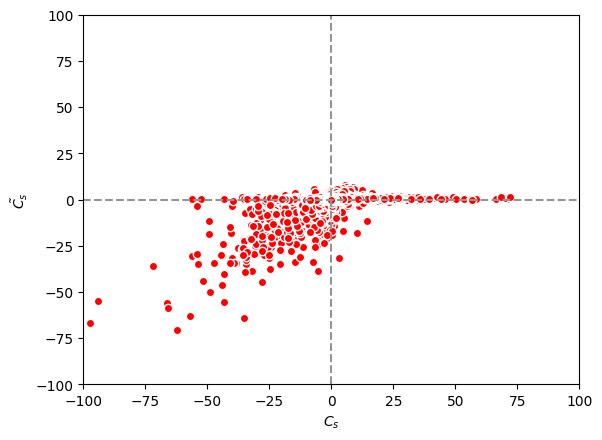

In [100]:
plt.scatter(test[:,-1], pred.detach().numpy(), edgecolor='white', color='red')
plt.plot([0, 0], [-100, 100], '--', color='#929591')
plt.plot([-100, 100], [0, 0], '--', color='#929591')
plt.xlim([-100, 100])
plt.ylim([-100, 100])
plt.xlabel(r'$C_s$')
plt.ylabel(r'$\tilde{C_s}$')
plt.savefig(f'../nnTraining/Results/{dt_name}_correlation.png')

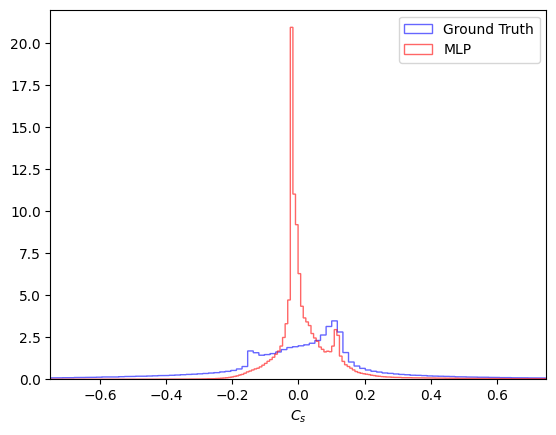

In [101]:
plt.hist(test[:,-1], bins=10000, density=True, alpha=0.6, histtype=u'step', color='blue')
plt.hist(pred.detach().numpy(), bins=10000, density=True, alpha=0.6, histtype=u'step', color='red')
plt.xlim([-0.75, 0.75])
plt.xlabel(r'$C_s$')
plt.legend(['Ground Truth', 'MLP'])
plt.savefig(f'../nnTraining/Results/{dt_name}_density.png')